In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ***`Libraries`***

In [17]:
!pip install --upgrade mlxtend
!pip install kmodes
!pip install gower
!pip install scikit-learn
!pip install --upgrade jax jaxlib
!pip install scipy


In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.spatial.distance import cdist
from sklearn.mixture import GaussianMixture
from kmodes.kprototypes import KPrototypes
import scipy.cluster.hierarchy as sch
import gower
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt

In [19]:
  import warnings
  warnings.filterwarnings("ignore")

# ***`EDA`***

In [20]:
df_cleaned = pd.read_excel('/content/drive/My Drive/Colab Notebooks/NCKH (Ph. Danh Hường)/Data thô/data_cleaned.xlsx')
df_cleaned.head(2)

,Name_Shop,revenue,positive,negative,total_feedback,Year_Joined,Shop_Rating,Counter_Rating,Followers,Chat Resopnse
0,2N Unisex,1326000,233,46,279,5,4.7,1100,982,0
1,3M Automotive Official,25545495,312,104,416,4,4.7,1400,1500,0


In [21]:
null_values = df_cleaned.isnull().sum()
print(null_values)

Name_Shop         0
revenue           0
positive          0
negative          0
total_feedback    0
Year_Joined       0
Shop_Rating       0
Counter_Rating    0
Followers         0
Chat Resopnse     0
dtype: int64


In [22]:
df_cleaned['Chat Resopnse'] = df_cleaned['Chat Resopnse'] / 100
df_cleaned = df_cleaned.drop(columns=['Name_Shop'])
df_cleaned['Year_Joined'] = df_cleaned['Year_Joined'].replace(0, 1)
df_cleaned = df_cleaned[df_cleaned['Counter_Rating'] != 0]

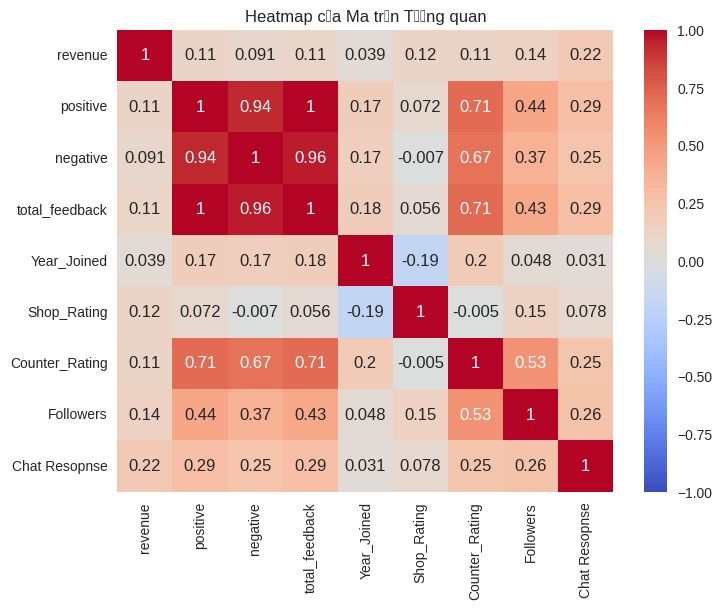

In [23]:
# Tính toán ma trận tương quan
correlation_matrix = df_cleaned.corr()

# Vẽ heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Heatmap của Ma trận Tương quan")
plt.show()

# ***`Wilson score interval`***

In [24]:
import pandas as pd
import numpy as np
from scipy.stats import norm

# Giả sử bạn có DataFrame df với các cột Shop_Rating và Counter_Rating
# Xác định z cho mức độ tin cậy mong muốn (95% confidence level)
z = norm.ppf(0.975)  # z = 1.96 cho mức độ tin cậy 95%

# Hàm tính điểm Wilson
def wilson_score(average_rating, total_ratings, z=z):
    p_hat = average_rating / 5  # Chuyển đổi Shop_Rating thành tỷ lệ giữa 0 và 1
    denominator = 1 + z**2 / total_ratings
    center_adjusted_probability = p_hat + z**2 / (2 * total_ratings)
    adjusted_standard_deviation = z * np.sqrt((p_hat * (1 - p_hat) + z**2 / (4 * total_ratings)) / total_ratings)
    wilson_lower_bound = (center_adjusted_probability - adjusted_standard_deviation) / denominator
    return wilson_lower_bound * 5  # Quy đổi về thang 5 sao

# Áp dụng hàm vào cột mới 'Wilson_Score' trong DataFrame
# Thay đổi ở đây: Truyền các giá trị của từng hàng vào hàm wilson_score
df_cleaned['Rating_quality'] = df_cleaned.apply(lambda x: wilson_score(x['Shop_Rating'], x['Counter_Rating']), axis=1)

In [25]:
import pandas as pd
import numpy as np
from scipy.stats import norm

# Giả sử bạn có DataFrame df với các cột positive, negative, total_feedback
# Xác định z cho mức độ tin cậy mong muốn (95% confidence level)
z = norm.ppf(0.975)  # z = 1.96 cho mức độ tin cậy 95%

# Hàm tính điểm Wilson
def wilson_score(positive, total_feedback, z=z):
    if total_feedback == 0:
        return 0  # Trả về 0 nếu không có feedback nào
    p_hat = positive / total_feedback  # Tỷ lệ tích cực
    denominator = 1 + z**2 / total_feedback
    center_adjusted_probability = p_hat + z**2 / (2 * total_feedback)
    adjusted_standard_deviation = z * np.sqrt((p_hat * (1 - p_hat) + z**2 / (4 * total_feedback)) / total_feedback)
    wilson_lower_bound = (center_adjusted_probability - adjusted_standard_deviation) / denominator
    return wilson_lower_bound

# Áp dụng hàm vào cột mới 'Wilson_Score_Positive' trong DataFrame
df_cleaned['Positive_quality'] = df_cleaned.apply(lambda x: wilson_score(x['positive'], x['total_feedback']), axis=1)
df_cleaned['Negative_quality'] = df_cleaned.apply(lambda x: wilson_score(x['negative'], x['total_feedback']), axis=1)

In [26]:
df_cleaned = df_cleaned.drop(columns=['positive', 'negative', 'total_feedback', 'Shop_Rating', 'Counter_Rating'])

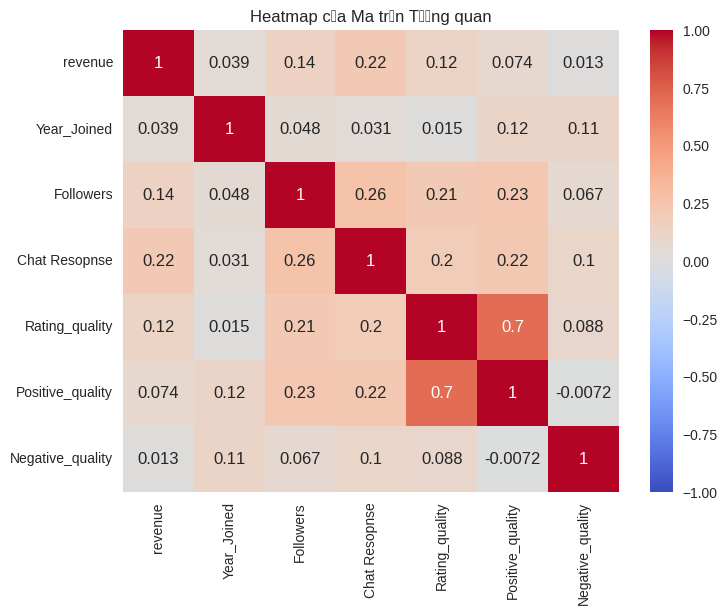

In [27]:
# Tính toán ma trận tương quan
correlation_matrix = df_cleaned.corr()

# Vẽ heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Heatmap của Ma trận Tương quan")
plt.show()

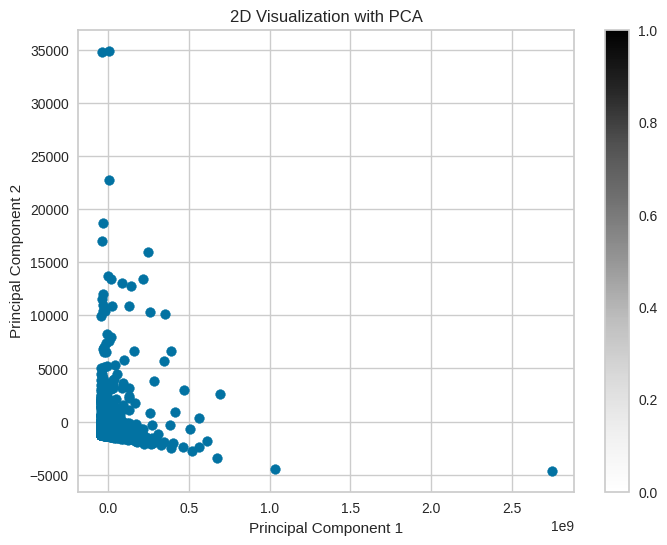

In [28]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Giả sử bạn có dữ liệu nhiều chiều trong X
# Sử dụng PCA để giảm xuống còn 2 thành phần
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_cleaned)

# Trực quan hóa dữ liệu
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], cmap='viridis')  # Thay labels bằng nhãn cụm nếu có
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D Visualization with PCA')
plt.colorbar()
plt.show()


# ***`Describe`***

In [29]:
df_copy_temp =  df_cleaned.copy()
df_copy_temp.describe()

,revenue,Year_Joined,Followers,Chat Resopnse,Rating_quality,Positive_quality,Negative_quality
count,9.330000e+02,933.000000,933.000000,933.000000,933.000000,933.000000,9.330000e+02
mean,4.443773e+07,5.403001,1407.422294,0.349400,4.390583,0.678008,1.519230e-01
std,1.319756e+08,1.442931,2965.526020,0.426577,0.447215,0.149187,7.024972e-02
min,0.000000e+00,1.000000,1.000000,0.000000,0.472656,0.000000,-1.173174e-17
25%,1.712999e+06,4.000000,140.000000,0.000000,4.296420,0.641034,1.067422e-01
50%,7.390000e+06,6.000000,479.000000,0.000000,4.493360,0.715368,1.544219e-01
75%,2.980900e+07,7.000000,1395.000000,0.830000,4.638440,0.771763,2.013693e-01
max,2.792880e+09,8.000000,36317.000000,1.000000,4.963264,0.927649,4.171295e-01


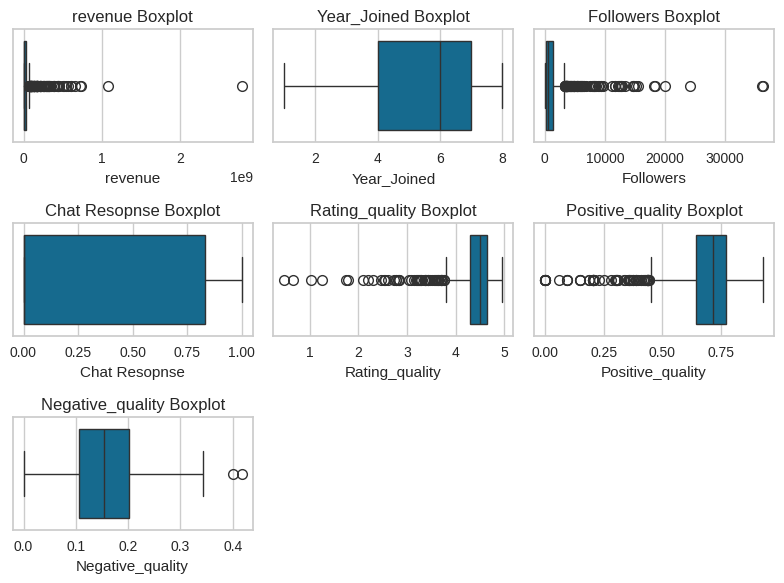

In [30]:
# Visualize the boxplot of each variable.
plt.figure(figsize=(8, 6))
for i, j in enumerate(df_copy_temp.describe().columns):
    plt.subplot(3,3, i+1)
    sns.boxplot(x=df_copy_temp[j])
    plt.title('{} Boxplot'.format(j))
    plt.tight_layout()

plt.show()

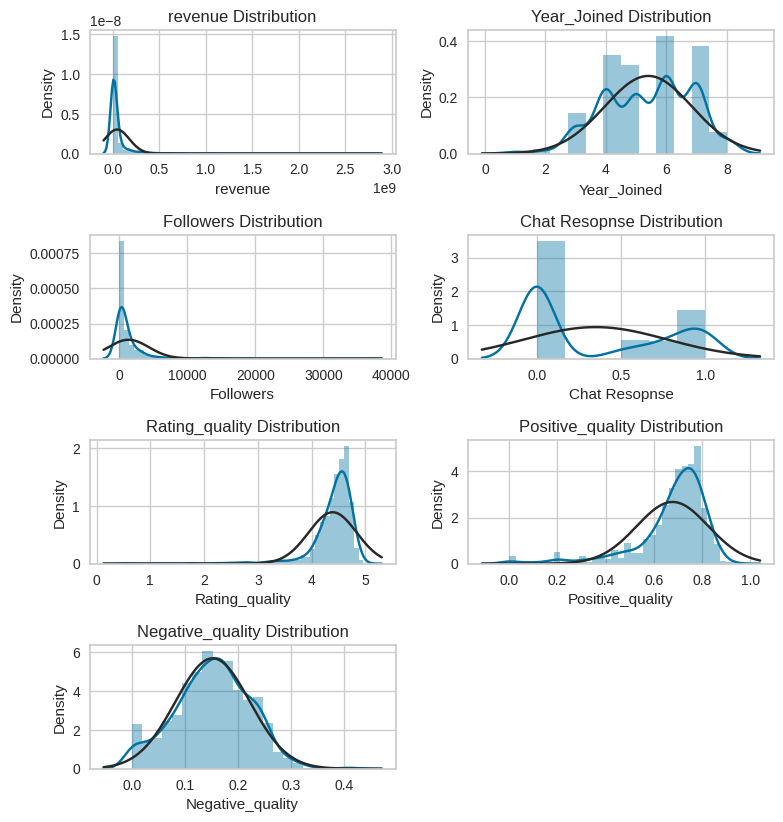

In [31]:
import scipy.stats as stats

# Visualize the distribution of each variable.
plt.figure(figsize=(8, 10))
for i, j in enumerate(df_copy_temp.describe().columns):
    plt.subplot(5,2, i+1)
    sns.distplot(x=df_copy_temp[j], fit = stats.norm)
    plt.xlabel(j)
    plt.title('{} Distribution'.format(j))
    plt.tight_layout()
plt.show()

# ***`Box-Cox Transformation`***

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Tạo bản sao DataFrame để lưu dữ liệu đã biến đổi
df_transformed = df_copy_temp.copy()

# Áp dụng Box-Cox Transformation cho từng cột và lưu giá trị lambda
lambdas = {}
for col in column_name:
    # Shift data to be positive if it contains non-positive values
    data = df_copy_temp[col]
    min_val = data.min()
    if min_val <= 0:
        shift = 1 - min_val  # Shift by 1 more than the minimum value
        data = data + shift

    df_transformed[col], fitted_lambda = stats.boxcox(data)
    lambdas[col] = fitted_lambda  # Lưu lambda tối ưu cho từng cột
    print(f"Giá trị lambda tối ưu cho cột {col} là: {fitted_lambda}")

# Lưu hoặc sử dụng df_transformed cho các bước tiếp theo
print(df_transformed.head())

Giá trị lambda tối ưu cho cột revenue là: 0.16507821692950747
Giá trị lambda tối ưu cho cột Followers là: 0.0675019422576115
Giá trị lambda tối ưu cho cột Rating_quality là: 7.329399416577202
Giá trị lambda tối ưu cho cột Positive_quality là: 7.4011600124138734
     revenue  Year_Joined  Followers  Chat Resopnse  Rating_quality  \
0  56.030435            5   8.771762            0.0    10177.601839   
1  95.122685            4   9.455963            0.0    10335.142382   
2  80.642937            6  13.066988            1.0    11275.512823   
3  65.556761            7   7.656052            0.0     6529.858292   
4  74.807825            6   7.907914            1.0     9225.474685   

   Positive_quality  Negative_quality  
0          9.793245      1.259429e-01  
1          6.912581      2.108047e-01  
2         12.454451     -1.173174e-17  
3          8.462914      1.914921e-01  
4         10.022589      1.589385e-01  


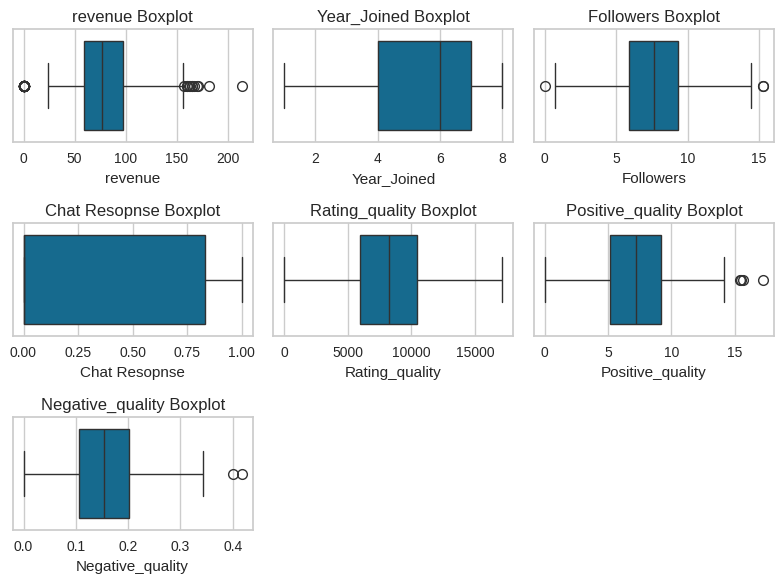

In [ ]:
# Visualize the boxplot of each variable.
plt.figure(figsize=(8, 6))
for i, j in enumerate(df_transformed.columns):
    plt.subplot(3,3, i+1)
    sns.boxplot(x=df_transformed[j])
    plt.title('{} Boxplot'.format(j))
    plt.tight_layout()

plt.show()

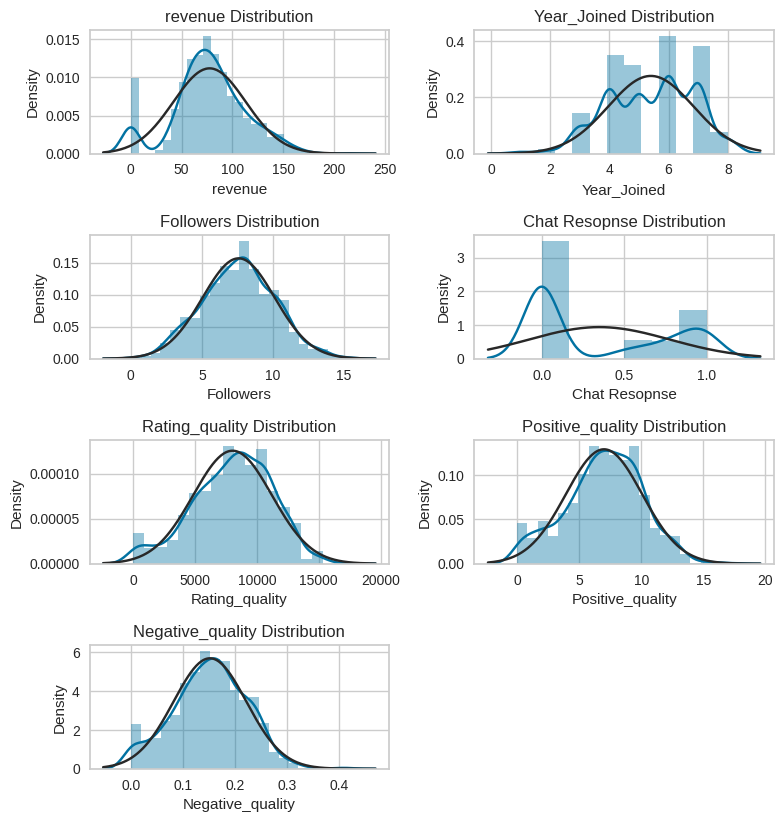

In [ ]:
import scipy.stats as stats

# Visualize the distribution of each variable.
plt.figure(figsize=(8, 10))
for i, j in enumerate(df_transformed.columns):
    plt.subplot(5,2, i+1)
    sns.distplot(x=df_transformed[j], fit = stats.norm)
    plt.xlabel(j)
    plt.title('{} Distribution'.format(j))
    plt.tight_layout()
plt.show()

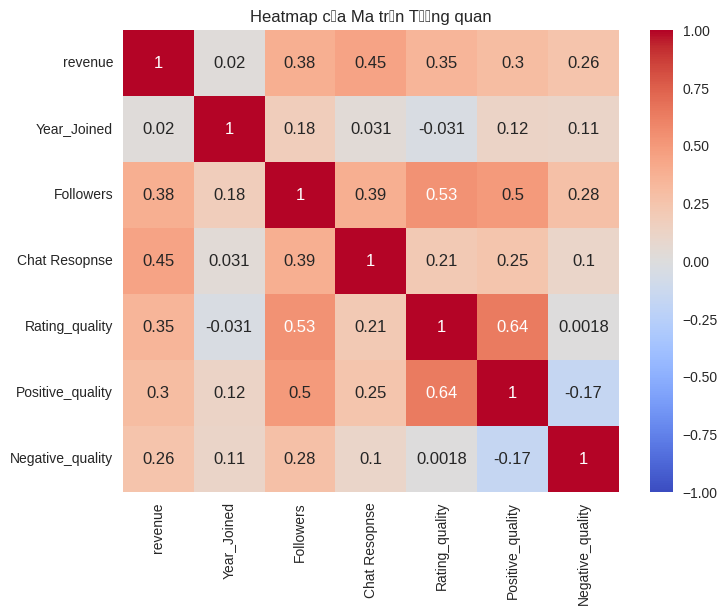

In [ ]:
# Tính toán ma trận tương quan
correlation_matrix = df_transformed.corr()

# Vẽ heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Heatmap của Ma trận Tương quan")
plt.show()

In [ ]:
df_copy_temp_log = df_transformed.copy()

# ***`Z-Score`***

In [32]:
# Khởi tạo StandardScaler
scaler = StandardScaler()

# Chuẩn hóa dữ liệu
scaled_data = scaler.fit_transform(df_copy_temp)
scaled_df = pd.DataFrame(scaled_data, columns=df_copy_temp.columns)

# ***`Winsorization `***

In [36]:
columns_to_winsorize = ['revenue', 'Followers', 'Rating_quality', 'Positive_quality', 'Negative_quality']

for col in columns_to_winsorize:
    scaled_df[col] = winsorize(scaled_df[col], limits=[0.05, 0.05])

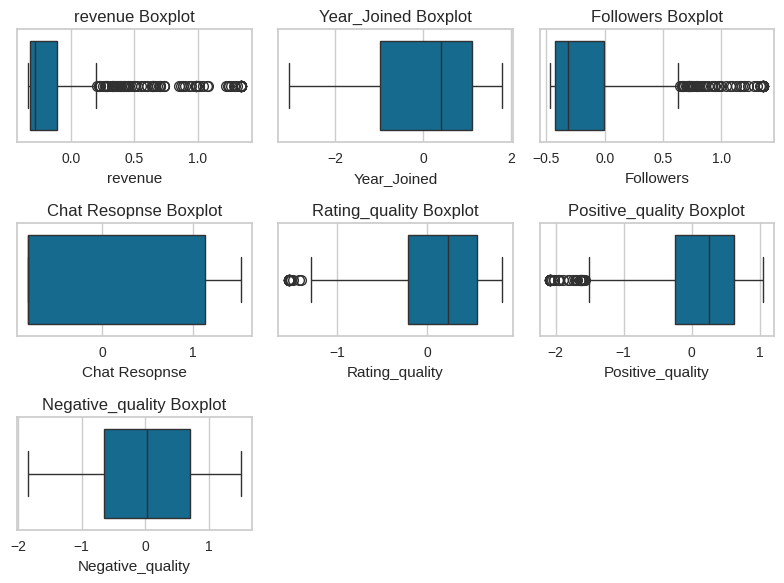

In [37]:
# Visualize the boxplot of each variable.
plt.figure(figsize=(8, 6))
for i, j in enumerate(scaled_df.columns):
    plt.subplot(3,3, i+1)
    sns.boxplot(x=scaled_df[j])
    plt.title('{} Boxplot'.format(j))
    plt.tight_layout()

plt.show()

# ***`Isolation Forest`***

In [38]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import IsolationForest # Import IsolationForest from sklearn.ensemble

# Áp dụng Isolation Forest với contamination=0.1
iso_forest = IsolationForest(contamination=0.1, random_state=42)
outlier_pred = iso_forest.fit_predict(scaled_df)

# Lọc ra các điểm không phải outlier
inliers_df = scaled_df[outlier_pred == 1]

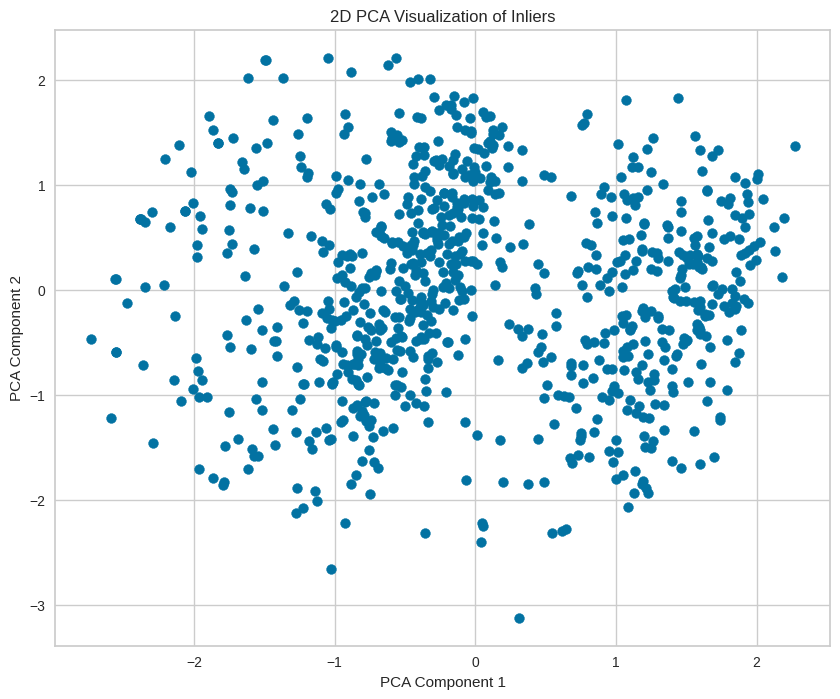

In [39]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Áp dụng PCA để giảm số chiều xuống 2
pca = PCA(n_components=2)
inliers_pca_2d = pca.fit_transform(inliers_df)

# Vẽ biểu đồ phân tán 2D
plt.figure(figsize=(10, 8))
plt.scatter(inliers_pca_2d[:, 0], inliers_pca_2d[:, 1], c='b', marker='o', s=50)

# Gán nhãn cho các trục
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('2D PCA Visualization of Inliers')

plt.show()


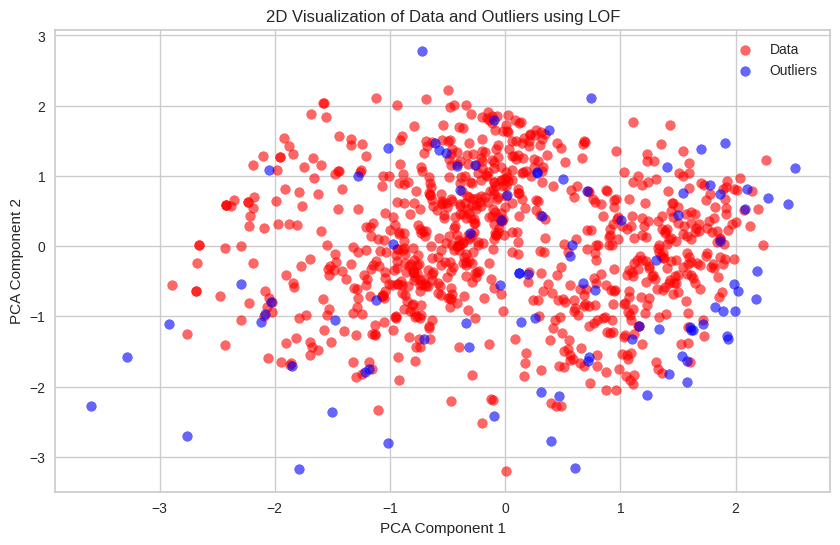

In [40]:
# Sử dụng PCA để giảm xuống 2 chiều để hiển thị
pca_2d = PCA(n_components=2, random_state=42)
df_pca_2d = pca_2d.fit_transform(scaled_df)

# Phân loại dữ liệu và outliers cho 2D (sử dụng LOF như yêu cầu cuối cùng)
df_pca_2d_data_lof = df_pca_2d[outlier_pred == 1]    # Các điểm bình thường
df_pca_2d_outliers_lof = df_pca_2d[outlier_pred == -1]  # Các outliers

# Visualize dữ liệu trong không gian 2D với LOF
plt.figure(figsize=(10, 6))
plt.scatter(df_pca_2d_data_lof[:, 0], df_pca_2d_data_lof[:, 1], color='red', label="Data", alpha=0.6)
plt.scatter(df_pca_2d_outliers_lof[:, 0], df_pca_2d_outliers_lof[:, 1], color='blue', label="Outliers", alpha=0.6)
plt.title("2D Visualization of Data and Outliers using LOF")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()


# ***`DBSCAN`***

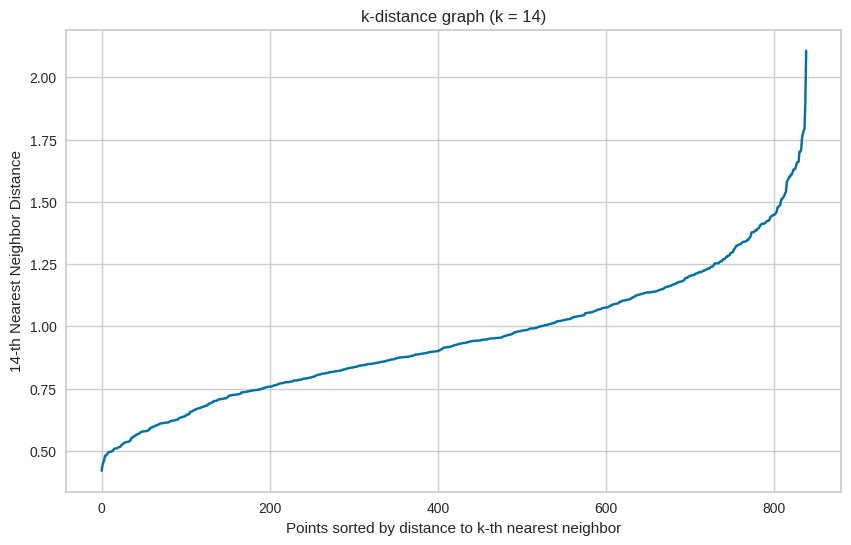

In [41]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

X = inliers_df

# Bước 1: Chọn giá trị min_samples (minpts) - thường là 5 hoặc 10 tùy thuộc vào dữ liệu
min_samples = 14  # Giá trị thử nghiệm

# Bước 2: Tính toán khoảng cách đến min_samples lân cận gần nhất
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

# Sắp xếp các khoảng cách để tìm "góc gãy" trên đồ thị
distances = np.sort(distances[:, min_samples - 1])  # Chọn khoảng cách đến điểm lân cận thứ min_samples

# Bước 3: Vẽ đồ thị k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title(f'k-distance graph (k = {min_samples})')
plt.xlabel("Points sorted by distance to k-th nearest neighbor")
plt.ylabel(f"{min_samples}-th Nearest Neighbor Distance")
plt.grid(True)
plt.show()


In [42]:
dbscan = DBSCAN(eps=1.5, min_samples=14)
dbscan_labels = dbscan.fit_predict(X)

# Count the number of clusters and noise points
unique_labels, counts = np.unique(dbscan_labels, return_counts=True)
clusters_info = dict(zip(unique_labels, counts))

clusters_info

{-1: 1, 0: 838}

In [43]:
non_noise_mask = dbscan_labels != -1
X_non_noise = X[non_noise_mask]

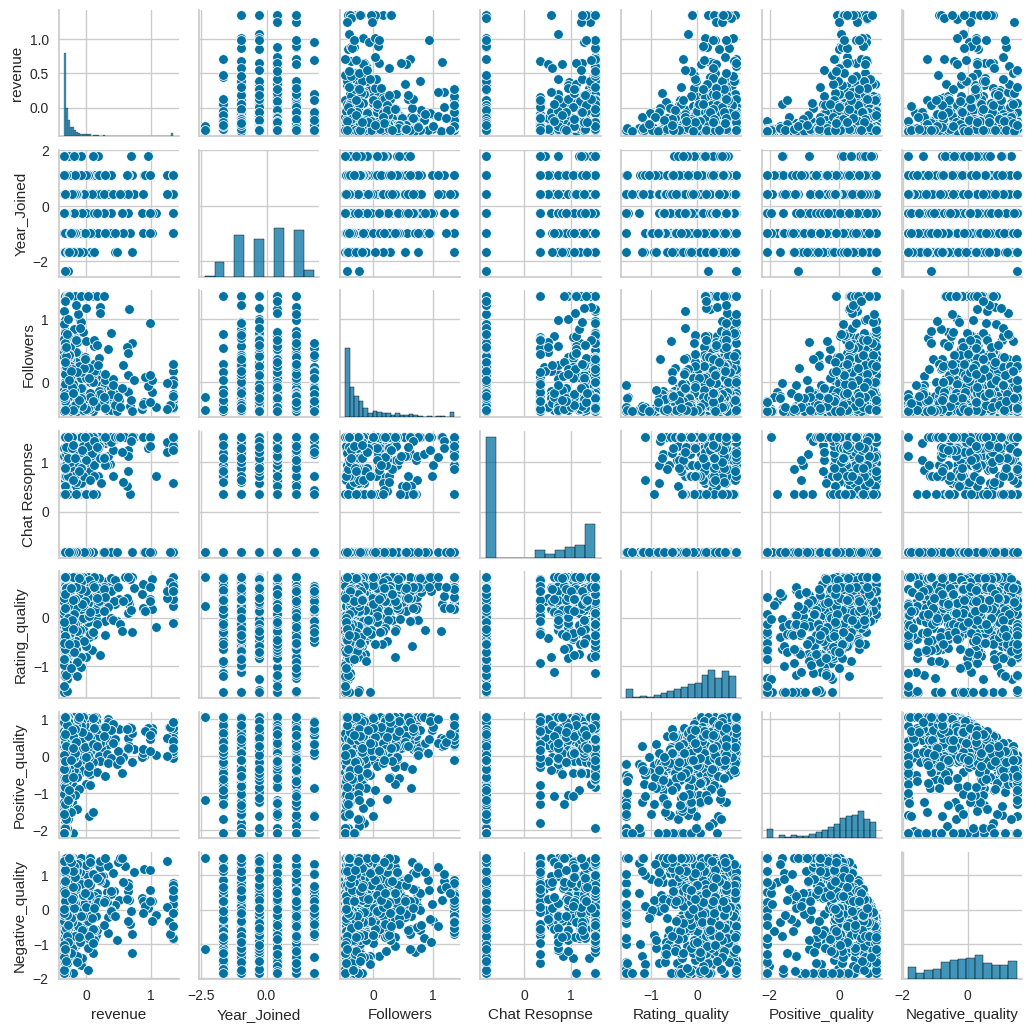

In [50]:
sns.pairplot(X_non_noise, height=1.5)
plt.show()

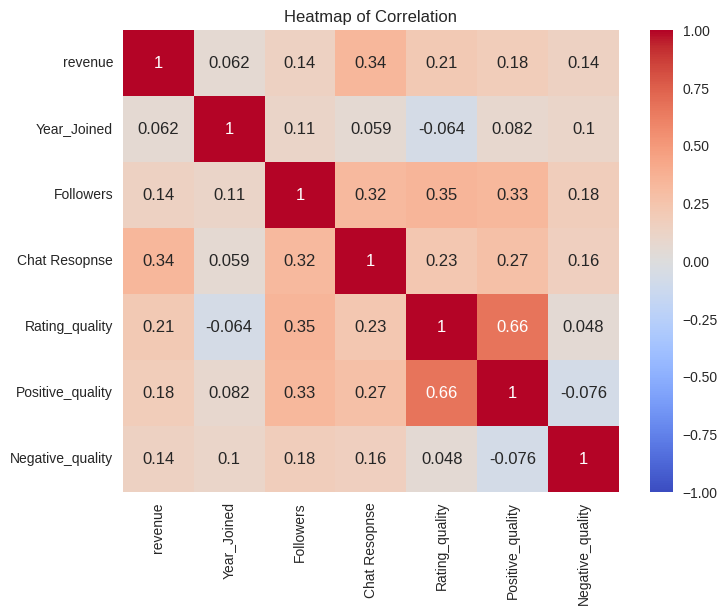

In [51]:
correlation_matrix = X_non_noise.corr()

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Heatmap of Correlation")
plt.show()

# ***`K-Means`***

Số cụm = 2, Điểm Silhouette trung bình = 0.17983293135310963
Số cụm = 3, Điểm Silhouette trung bình = 0.23396045489953246
Số cụm = 4, Điểm Silhouette trung bình = 0.21063936275276673
Số cụm = 5, Điểm Silhouette trung bình = 0.22141783167701679
Số cụm = 6, Điểm Silhouette trung bình = 0.22598292157715266
Số cụm = 7, Điểm Silhouette trung bình = 0.22087030066163563
Số cụm = 8, Điểm Silhouette trung bình = 0.21990440222292001
Số cụm = 9, Điểm Silhouette trung bình = 0.22885000154740673
Số cụm = 10, Điểm Silhouette trung bình = 0.22443553368107055


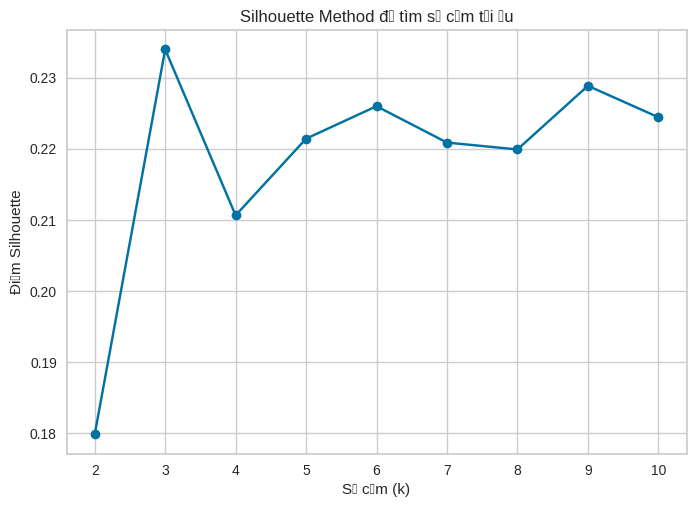

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Tạo một danh sách để lưu điểm Silhouette cho mỗi số cụm
silhouette_scores = []

# Đặt phạm vi số cụm muốn kiểm tra (ví dụ: từ 2 đến 10)
range_n_clusters = range(2, 11)

# Tính điểm Silhouette cho mỗi số cụm
for n_clusters in range_n_clusters:
    # Sử dụng K++ với init='k-means++'
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
    cluster_labels = kmeans.fit_predict(X_non_noise)  # Giả sử X_non_noise là dữ liệu đã chuẩn hóa hoặc biến đổi

    # Tính điểm Silhouette trung bình cho số cụm hiện tại
    silhouette_avg = silhouette_score(X_non_noise, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"Số cụm = {n_clusters}, Điểm Silhouette trung bình = {silhouette_avg}")

# Vẽ đồ thị số cụm so với điểm Silhouette
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel('Số cụm (k)')
plt.ylabel('Điểm Silhouette')
plt.title('Silhouette Method để tìm số cụm tối ưu')
plt.show()


# ***`GMM`***

Số cụm = 2, BIC = 13643.497127205455
Số cụm = 3, BIC = 12667.269139564789
Số cụm = 4, BIC = 10598.444523821208
Số cụm = 5, BIC = 8851.028043376287
Số cụm = 6, BIC = 6848.211838153353
Số cụm = 7, BIC = 5296.754554891402
Số cụm = 8, BIC = 2713.545897142391
Số cụm = 9, BIC = 1413.087200062485
Số cụm = 10, BIC = 1242.4630369209217


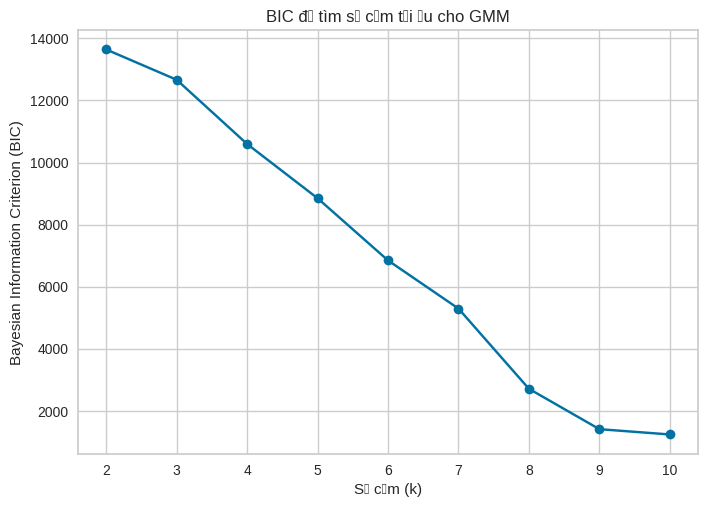

In [ ]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# Phạm vi số cụm muốn kiểm tra (ví dụ: từ 1 đến 10)
range_n_clusters = range(2, 11)

# Danh sách để lưu giá trị BIC cho mỗi số cụm
bic_scores = []

# Tính BIC cho mỗi số cụm
for n_clusters in range_n_clusters:
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm.fit(X_non_noise)  # Giả sử X_non_noise là dữ liệu đã chuẩn hóa hoặc biến đổi
    bic_scores.append(gmm.bic(X_non_noise))
    print(f"Số cụm = {n_clusters}, BIC = {bic_scores[-1]}")

# Vẽ đồ thị số cụm so với BIC
plt.plot(range_n_clusters, bic_scores, marker='o')
plt.xlabel('Số cụm (k)')
plt.ylabel('Bayesian Information Criterion (BIC)')
plt.title('BIC để tìm số cụm tối ưu cho GMM')
plt.show()


# ***`PCA`***

In [ ]:
# Giả định dữ liệu được lưu trong DataFrame df
# với các cột như trong heatmap
def perform_pca_analysis(X_non_noise):
    # Chuẩn hóa dữ liệu
    # scaler = StandardScaler()
    # scaled_data = scaler.fit_transform(df)

    # Thực hiện PCA
    pca = PCA()
    pca_result = pca.fit_transform(X_non_noise)

    # Tính tỷ lệ giải thích phương sai
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

    # Vẽ biểu đồ scree plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(explained_variance_ratio) + 1),
             cumulative_variance_ratio, 'bo-')
    plt.plot([0, len(explained_variance_ratio) + 1], [0.8, 0.8], 'r--')
    plt.xlabel('Số thành phần chính')
    plt.ylabel('Tỷ lệ phương sai tích lũy')
    plt.title('Scree Plot')
    plt.grid(True)

    # In ra contribution của các thành phần
    components_df = pd.DataFrame(
        pca.components_.T,
        columns=[f'PC{i+1}' for i in range(len(X_non_noise.columns))],
        index=X_non_noise.columns
    )

    # Vẽ heatmap cho 3 thành phần đầu tiên
    plt.figure(figsize=(10, 8))
    sns.heatmap(components_df.iloc[:, :3], annot=True, cmap='coolwarm')
    plt.title('PCA Components Heatmap')

    return {
        'explained_variance_ratio': explained_variance_ratio,
        'cumulative_variance_ratio': cumulative_variance_ratio,
        'components': components_df,
        'transformed_data': pca_result
    }

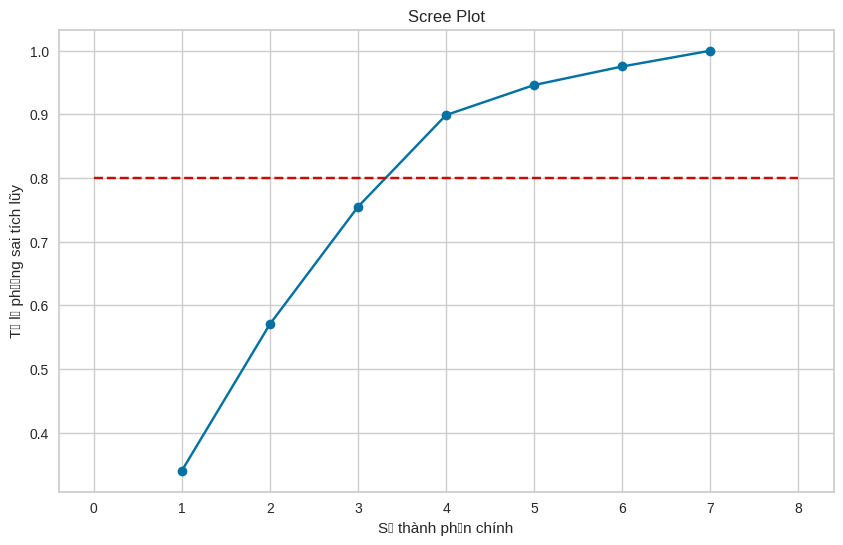

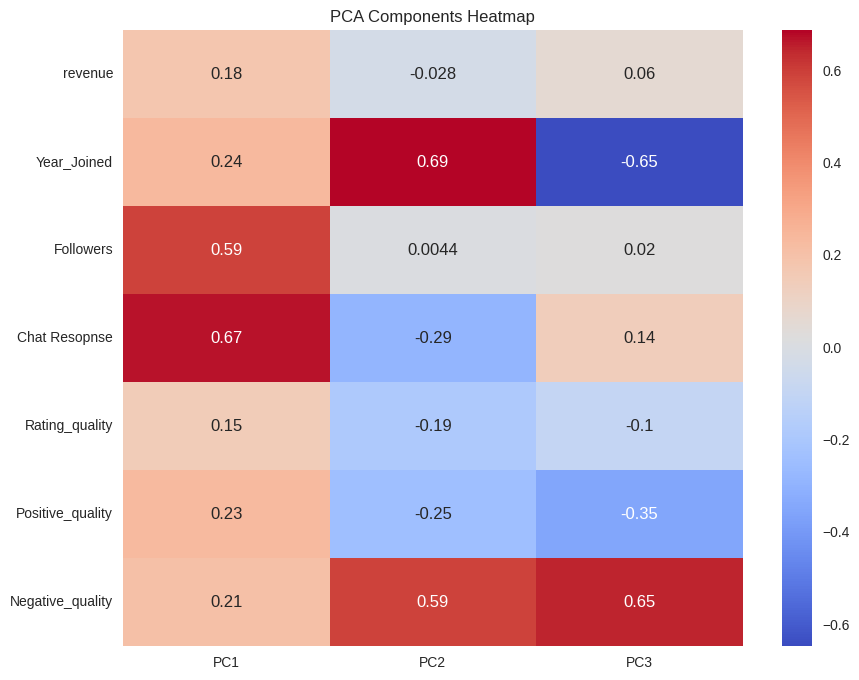

In [ ]:
results = perform_pca_analysis(X_non_noise)

In [ ]:
# Hàm để chọn số thành phần chính tối ưu
def select_optimal_components(cumulative_variance_ratio, threshold=0.8):
    return np.argmax(cumulative_variance_ratio >= threshold) + 1

In [ ]:
n_components = select_optimal_components(results['cumulative_variance_ratio'])
print(f"Số thành phần chính đề xuất: {n_components}")

Số thành phần chính đề xuất: 4


In [ ]:
def apply_pca_reduction(X_non_noise, n_components):

    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(X_non_noise)

    # Tạo DataFrame với dữ liệu đã giảm chiều
    columns = [f'PC{i+1}' for i in range(n_components)]
    reduced_df = pd.DataFrame(reduced_data, columns=columns)

    return reduced_df, pca

In [ ]:
reduced_df, pca_model = apply_pca_reduction(X_non_noise, n_components)

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Tạo một danh sách để lưu các giá trị silhouette score
silhouette_scores = []

# Thử nghiệm với các số cụm từ 2 đến 10
for n_clusters in range(2, 15):
    # Khởi tạo và huấn luyện K-means với n_clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(reduced_df)  # X_reduced là dữ liệu đã giảm chiều

    # Tính chỉ số silhouette
    silhouette_avg = silhouette_score(reduced_df, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"Số cụm: {n_clusters}, Silhouette Score: {silhouette_avg:.3f}")

# Tìm số cụm tối ưu (tối đa silhouette score)
optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2  # +2 vì range bắt đầu từ 2
print(f"Số cụm tối ưu là: {optimal_clusters}")


Số cụm: 2, Silhouette Score: 0.294
Số cụm: 3, Silhouette Score: 0.254
Số cụm: 4, Silhouette Score: 0.236
Số cụm: 5, Silhouette Score: 0.228
Số cụm: 6, Silhouette Score: 0.234
Số cụm: 7, Silhouette Score: 0.230
Số cụm: 8, Silhouette Score: 0.240
Số cụm: 9, Silhouette Score: 0.248
Số cụm: 10, Silhouette Score: 0.248
Số cụm: 11, Silhouette Score: 0.247
Số cụm: 12, Silhouette Score: 0.240
Số cụm: 13, Silhouette Score: 0.233
Số cụm: 14, Silhouette Score: 0.222
Số cụm tối ưu là: 2


In [ ]:
# Áp dụng K-means trên dữ liệu đã giảm chiều
kmeans = KMeans(n_clusters=11, random_state=42)  # Giả sử có 4 cụm
clusters = kmeans.fit_predict(reduced_df)

# Đánh giá chất lượng phân cụm với silhouette score
score = silhouette_score(reduced_df, clusters)
print("Silhouette Score:", score)


Silhouette Score: 0.24650693063390466


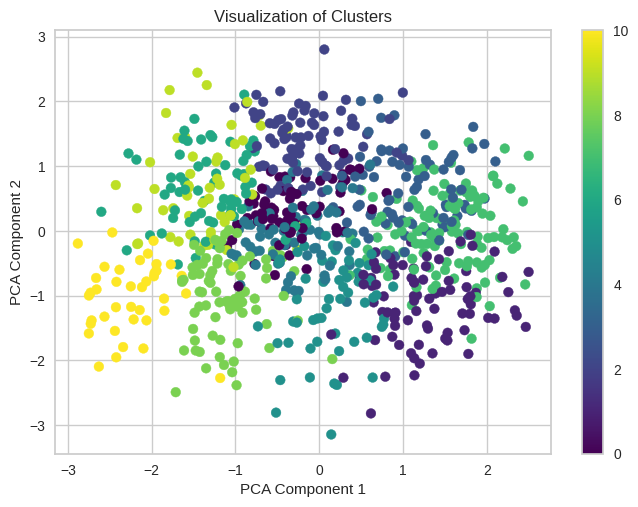

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Giảm dữ liệu xuống 2 chiều bằng PCA
pca = PCA(2)
reduced_data = pca.fit_transform(reduced_df)

# Vẽ biểu đồ
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis')
plt.title('Visualization of Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar()
plt.show()


# ***`Nhap`***

# ***`CLIQUE`***

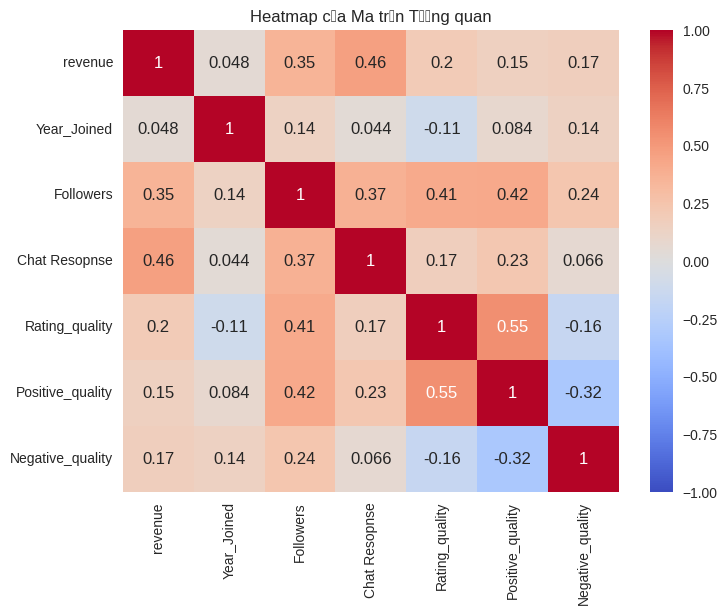

In [ ]:
# Tính toán ma trận tương quan
correlation_matrix = X_non_noise.corr()

# Vẽ heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Heatmap của Ma trận Tương quan")
plt.show()

In [ ]:
import numpy as np
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs

# Kích thước đầu vào và số chiều giảm xuống
input_dim = X_non_noise.shape[1]  # Số chiều của dữ liệu đầu vào (10 trong trường hợp này)
encoding_dim = 3  # Số chiều muốn giảm xuống

# Bộ mã hóa (Encoder)
input_layer = Input(shape=(input_dim,))
encoder_layer_1 = Dense(6, activation="relu")(input_layer)  # Lớp ẩn với 6 nơ-ron
encoder_output = Dense(encoding_dim, activation="relu")(encoder_layer_1)  # Lớp ẩn với 2 nơ-ron (giảm xuống 2 chiều)

# Bộ giải mã (Decoder)
decoder_layer_1 = Dense(6, activation="relu")(encoder_output)
decoder_output = Dense(input_dim, activation="sigmoid")(decoder_layer_1)

# Tạo Autoencoder
autoencoder = Model(inputs=input_layer, outputs=decoder_output)

# Tạo Encoder model riêng để lấy biểu diễn nén
encoder = Model(inputs=input_layer, outputs=encoder_output)

# Compile Autoencoder
autoencoder.compile(optimizer="adam", loss="mse")


In [ ]:
# Huấn luyện autoencoder
autoencoder.fit(X_non_noise, X_non_noise, epochs=50, batch_size=32, shuffle=True, validation_split=0.1)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.7501 - val_loss: 0.7730
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7376 - val_loss: 0.7549
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6963 - val_loss: 0.7347
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6781 - val_loss: 0.7123
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6506 - val_loss: 0.6907
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6520 - val_loss: 0.6721
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5989 - val_loss: 0.6568
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5767 - val_loss: 0.6432
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5586 - val_loss: 0.6329
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5707 - val_loss: 0.6231
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5426 - val_loss: 0.6147
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5387 - val_l

In [ ]:
# Trích xuất dữ liệu đã nén
X_reduced = encoder.predict(X_non_noise)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Tạo một danh sách để lưu các giá trị silhouette score
silhouette_scores = []

# Thử nghiệm với các số cụm từ 2 đến 10
for n_clusters in range(2, 15):
    # Khởi tạo và huấn luyện K-means với n_clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_reduced)  # X_reduced là dữ liệu đã giảm chiều

    # Tính chỉ số silhouette
    silhouette_avg = silhouette_score(X_reduced, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"Số cụm: {n_clusters}, Silhouette Score: {silhouette_avg:.3f}")

# Tìm số cụm tối ưu (tối đa silhouette score)
optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2  # +2 vì range bắt đầu từ 2
print(f"Số cụm tối ưu là: {optimal_clusters}")


Số cụm: 2, Silhouette Score: 0.365
Số cụm: 3, Silhouette Score: 0.304
Số cụm: 4, Silhouette Score: 0.346
Số cụm: 5, Silhouette Score: 0.376
Số cụm: 6, Silhouette Score: 0.363
Số cụm: 7, Silhouette Score: 0.368
Số cụm: 8, Silhouette Score: 0.354
Số cụm: 9, Silhouette Score: 0.362
Số cụm: 10, Silhouette Score: 0.343
Số cụm: 11, Silhouette Score: 0.339
Số cụm: 12, Silhouette Score: 0.336
Số cụm: 13, Silhouette Score: 0.338
Số cụm: 14, Silhouette Score: 0.338
Số cụm tối ưu là: 5


ValueError: x and y must have same first dimension, but have shapes (12,) and (13,)

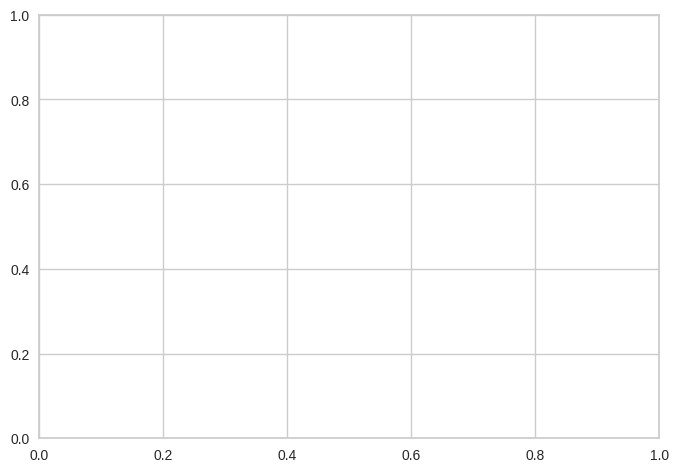

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(3, 15), silhouette_scores, marker='o')
plt.xlabel("Số cụm")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score theo số cụm")
plt.show()


In [ ]:
# Áp dụng K-means trên dữ liệu đã giảm chiều
kmeans = KMeans(n_clusters=5, random_state=42)  # Giả sử có 4 cụm
clusters = kmeans.fit_predict(X_reduced)

# Đánh giá chất lượng phân cụm với silhouette score
score = silhouette_score(X_reduced, clusters)
print("Silhouette Score:", score)


Silhouette Score: 0.37607357


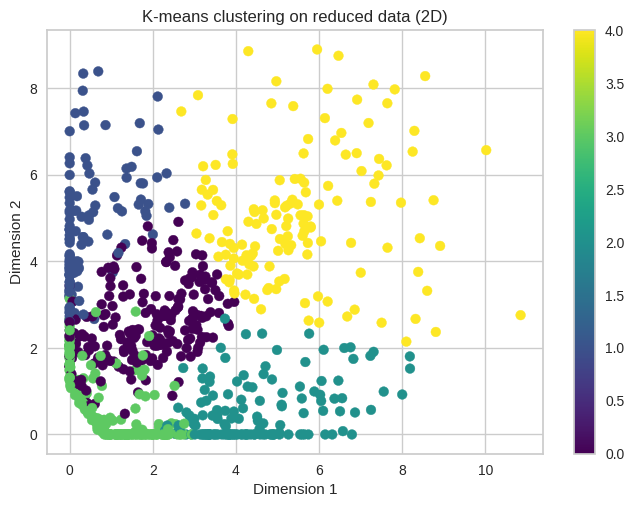

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=clusters, cmap='viridis')
plt.colorbar()
plt.title("K-means clustering on reduced data (2D)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

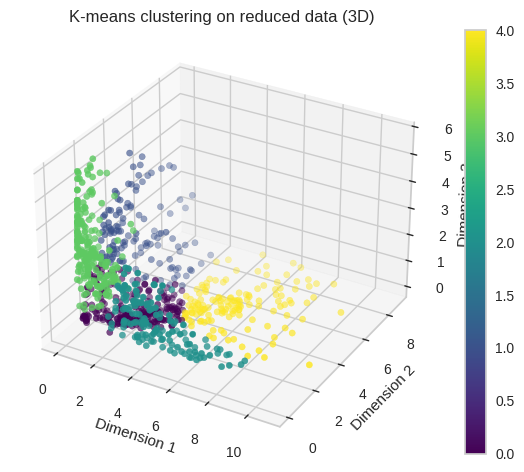

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming X_reduced has been reduced to three dimensions (e.g., using PCA)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotting the 3D scatter plot
sc = ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=clusters, cmap='viridis')
plt.colorbar(sc)

# Setting titles and labels
ax.set_title("K-means clustering on reduced data (3D)")
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
ax.set_zlabel("Dimension 3")

plt.show()


# ***`PCA`***